In [1]:
import numpy as np
from flowrec.utils.system import set_gpu
set_gpu(0,1)
import jax
import jax.numpy
from matplotlib import pyplot as plt
plt.style.use('./flowrec/utils/ppt.mplstyle')
from pathlib import Path

In [2]:
from flowrec.utils.simulation import read_data_volvo
import flowrec.physics_and_derivatives as derivatives
import flowrec.losses as losses
from flowrec.data import DataMetadata, normalise, unnormalise_group
from flowrec.utils.py_helper import slice_from_tuple

In [3]:
u_p, d, re, density = read_data_volvo('./local_data/volvorig/u166', nondimensional=True)
u_p.shape

(493, 40, 20, 20, 4)

In [4]:
datainfo = DataMetadata(
    re=re,
    discretisation=d,
    axis_index=[0,1,2,3],
    problem_2d=False,
).to_named_tuple()
datainfo

_Metadata3d(re=45272.49849853186, discretisation=(0.10374418999999165, 0.03205128205128194, 0.02631578947368436, 0.031578947368421026), axis_index=(0, 1, 2, 3), axt=0, axx=1, axy=2, axz=3, dt=0.10374418999999165, dx=0.03205128205128194, dy=0.02631578947368436, dz=0.031578947368421026)

# Slice: Load data and measurements

In [5]:
n_train = 200
u_train = u_p[:n_train,...]

In [6]:
z_plane = 10
y_skip = 1
inns_loc = np.s_[:,0:1,::y_skip,:,-1]
inns = u_train[inns_loc]
inns_shape = inns.shape
print(inns_shape)
inns = np.squeeze(inns)
y_loc = np.s_[:,:,:,z_plane,:-1]
y = u_train[y_loc]
print(inns.shape, y.shape)

(200, 1, 20, 20)
(200, 20, 20) (200, 40, 20, 3)


In [7]:
measured = np.empty_like(u_train)
measured[inns_loc] = inns.reshape(inns_shape)
measured[y_loc] = y
print(measured.shape)

(200, 40, 20, 20, 4)


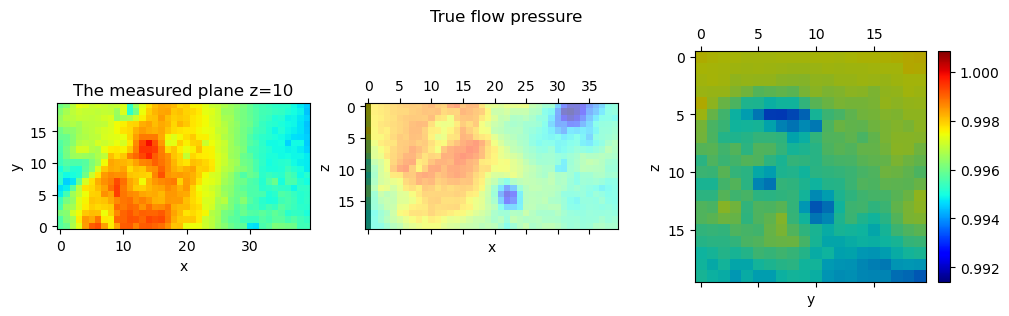

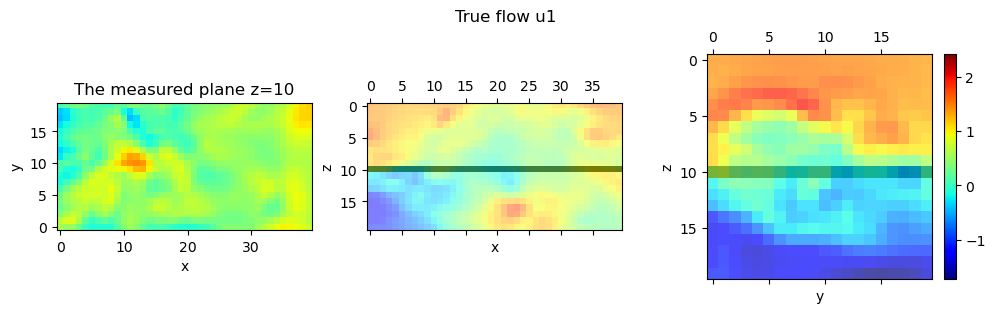

In [8]:
plt_t = 10
vmin = u_train[plt_t,...,-1].min()
vmax = u_train[plt_t,...,-1].max()
fig, axes = plt.subplots(1, 3, figsize=(10,3))
axes[0].set_title(f'The measured plane z={z_plane}')
axes[0].imshow(u_train[plt_t,:,:,z_plane,-1].T, vmin=vmin, vmax=vmax)
axes[0].set(xlabel='x', ylabel='y')
axes[1].imshow(u_train[plt_t,:,0,:,-1].T, vmin=vmin, vmax=vmax)
axes[1].spy(measured[plt_t,:,0,:,-1].T,alpha=0.5)
axes[1].set(xlabel='x', ylabel='z')
imyz = axes[2].imshow(u_train[plt_t,0,:,:,-1].T, vmin=vmin, vmax=vmax)
axes[2].spy(measured[plt_t,0,:,:,-1].T,alpha=0.3)
axes[2].set(xlabel='y', ylabel='z')
plt.colorbar(imyz)
fig.suptitle('True flow pressure')
plt.show()
vmin = u_train[plt_t,...,0].min()
vmax = u_train[plt_t,...,0].max()
fig, axes = plt.subplots(1, 3, figsize=(10,3))
axes[0].set_title(f'The measured plane z={z_plane}')
axes[0].imshow(u_train[plt_t,:,:,z_plane,0].T, vmin=vmin, vmax=vmax)
axes[0].set(xlabel='x', ylabel='y')
axes[1].imshow(u_train[plt_t,:,0,:,0].T, vmin=vmin, vmax=vmax)
axes[1].spy(measured[plt_t,:,0,:,0].T,alpha=0.5)
axes[1].set(xlabel='x', ylabel='z')
imyz = axes[2].imshow(u_train[plt_t,0,:,:,0].T, vmin=vmin, vmax=vmax)
axes[2].spy(measured[plt_t,0,:,:,0].T,alpha=0.3)
axes[2].set(xlabel='y', ylabel='z')
plt.colorbar(imyz)
fig.suptitle('True flow u1')
plt.show()

In [9]:
ld_ref = losses.divergence(u_train[...,:-1],datainfo)
lm_ref = losses.momentum_loss(u_train, datainfo)
print('Div and momentum loss ',ld_ref, lm_ref)

Div and momentum loss  1.3808253 74.10478


# Model

In [10]:
import flowrec.training_and_states as train
import optax
from train_config.train_options import optimizer as optimiser_options
import jax.numpy as jnp

In [11]:
key = jax.random.PRNGKey(10)

Normalise data

In [12]:
[inns_norm], inns_range = normalise(inns)
y_list, y_range = normalise(y[...,0],y[...,1],y[...,2])
y_norm = np.stack(y_list, axis=-1)
print(y_norm.shape)
refvelocity_norm, _ = normalise(u_train[...,0],u_train[...,1],u_train[...,2], range=y_range)
refvelocity_norm = np.stack(refvelocity_norm, axis=-1)

(200, 40, 20, 3)


## train on slices

In [13]:
from flowrec.models.feedforward import Model as FFMDL

In [14]:
mdl1 = FFMDL(
    layers=[128,256, 512, 1024,y[0,...].size],
)

In [15]:
lr = 0.0001

In [16]:
params1 = mdl1.init(key,inns_norm[:10,:,z_plane])
scheduler1 = optimiser_options.get_scheduler('exponential_decay', lr)
optimiser1 = optax.adamw(learning_rate=scheduler1)
opt_state1 = optimiser1.init(params1)
state1 = train.TrainingState(params=params1, opt_state=opt_state1)
mdl1.apply(state1.params, key, inns_norm[:10,:,z_plane]).shape

(10, 2400)

In [17]:
hist1 = []
best_l = jnp.inf

In [18]:
update1 = train.generate_update_fn(
    mdl1.apply,
    optimiser1,
    losses.loss_mse,
)
_l, _ = update1(state1, key, inns_norm[:10,:,z_plane], y_norm[:10,...].reshape((10,-1)))
print(_l)

0.08051046


epoch 0, loss 0.08195074647665024
epoch 20, loss 0.05356358736753464
epoch 40, loss 0.04330386221408844
epoch 60, loss 0.042680948972702026
epoch 80, loss 0.04224388673901558
epoch 100, loss 0.04185180366039276
epoch 120, loss 0.041481129825115204
epoch 140, loss 0.04112724959850311
epoch 160, loss 0.04079475253820419
epoch 180, loss 0.04049168899655342
epoch 200, loss 0.040213584899902344
epoch 220, loss 0.039947509765625
epoch 240, loss 0.039680831134319305
epoch 260, loss 0.03940413519740105
epoch 280, loss 0.03911617398262024
epoch 300, loss 0.03883025422692299
epoch 320, loss 0.038553666323423386
epoch 340, loss 0.03837946057319641
epoch 360, loss 0.038174163550138474
epoch 380, loss 0.03794805705547333
epoch 400, loss 0.03778235614299774
epoch 420, loss 0.03764572739601135
epoch 440, loss 0.037516649812459946
epoch 460, loss 0.03741319850087166
epoch 480, loss 0.037297844886779785
epoch 500, loss 0.03719160705804825
epoch 520, loss 0.037089742720127106
epoch 540, loss 0.036990407

Text(0, 0.5, 'loss mse')

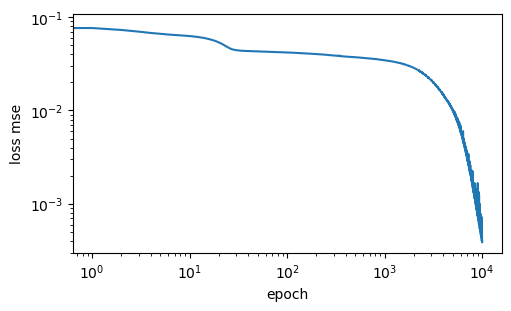

In [19]:
n_epochs = 10000
for i in range(n_epochs):
    [key] = jax.random.split(key,1)
    l_epoch = []
    j = 0
    while (j+1)*50 <= n_train :
        _l, state1 = update1(state1, key, inns_norm[j*50:(j+1)*50,:,z_plane], y_norm[j*50:(j+1)*50,...].reshape((50,-1)))
        j += 1
        l_epoch.append(_l)
    l = np.mean(l_epoch)
    hist1.append(l)
    if i % 20 == 0:
        print(f'epoch {i}, loss {l}')
    if l < best_l:
        best_state1 = state1
        best_l = l
plt.figure(figsize=(5,3))
plt.loglog(hist1)
plt.xlabel('epoch')
plt.ylabel('loss mse')

In [20]:
pred_slice_norm = mdl1.apply(best_state1.params, None, inns_norm[:,:,z_plane]).reshape(y.shape)

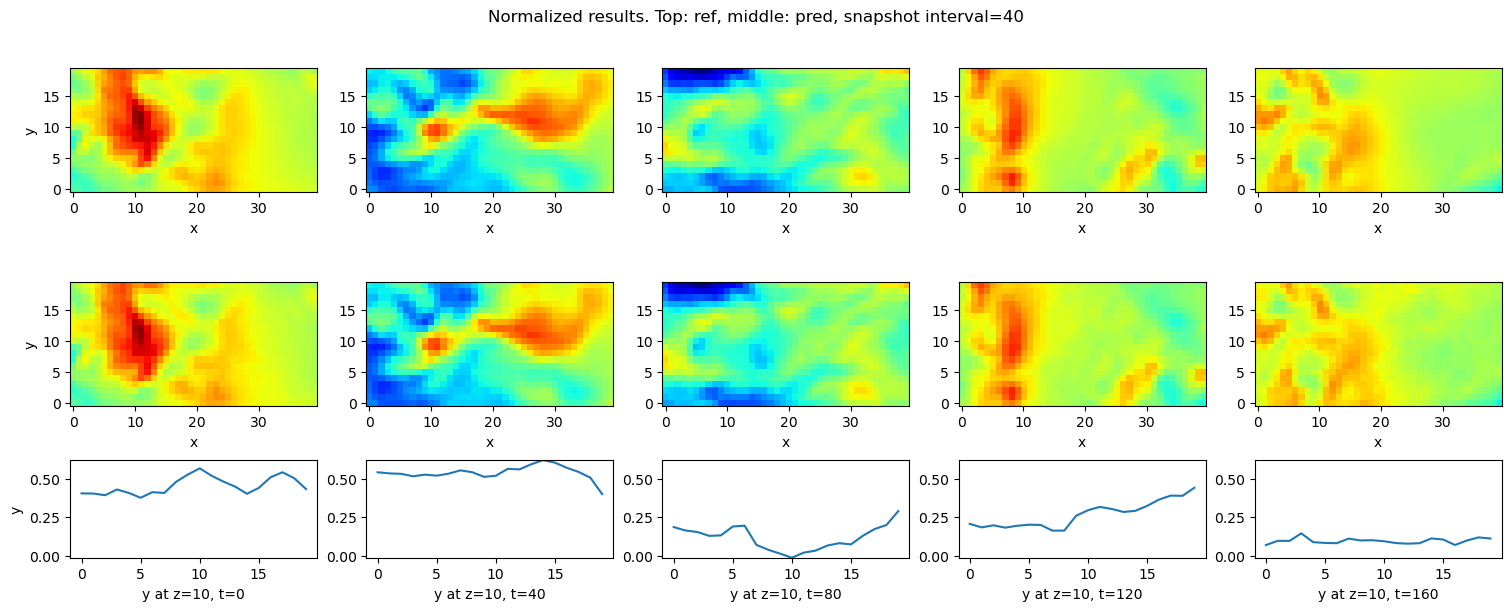

In [21]:
plt_step = 40
vmin = y_norm[::plt_step,...,0].min()
vmax = y_norm[::plt_step,...,0].max()
fig,axes = plt.subplots(3,5,figsize=(15,6),height_ratios=(0.4,0.4,0.2))
fig.suptitle(f'Normalized results. Top: ref, middle: pred, snapshot interval={plt_step}')
for i in range(5):
    axes[2,i].plot(inns_norm[i*plt_step,:,z_plane])
    axes[2,i].set(xlabel=f'y at z={z_plane}, t={i*plt_step}', ylim=[inns_norm[::plt_step,:,z_plane].min(), inns_norm[::plt_step,:,z_plane].max()])
    axes[0,i].imshow(y_norm[i*plt_step,...,0].T, vmin=vmin, vmax=vmax)
    axes[0,i].set(xlabel='x')
    axes[1,i].imshow(pred_slice_norm[i*plt_step,...,0].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')
axes[2,0].set_ylabel('y')
plt.show()

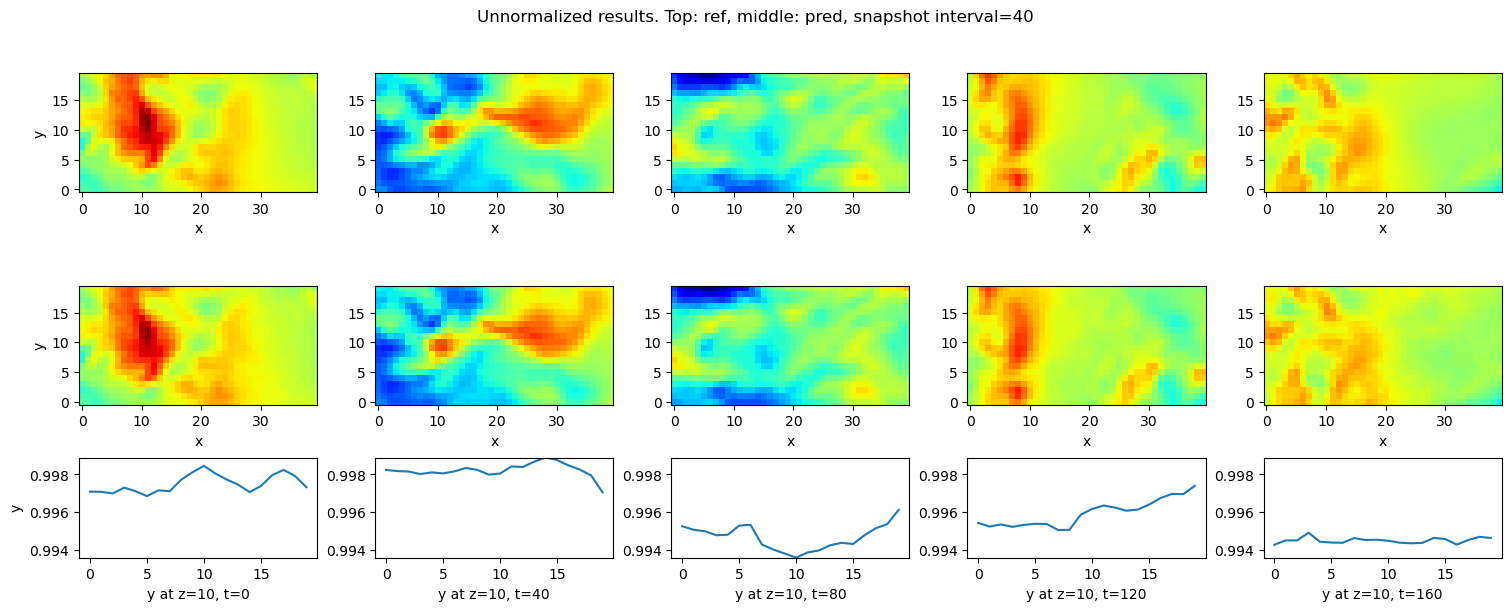

In [22]:
pred_slice = unnormalise_group(pred_slice_norm, data_range=y_range, axis_data=-1, axis_range=0)
vmin = y[::plt_step,...,0].min()
vmax = y[::plt_step,...,0].max()
fig,axes = plt.subplots(3,5,figsize=(15,6),height_ratios=(0.4,0.4,0.2))
fig.suptitle(f'Unnormalized results. Top: ref, middle: pred, snapshot interval={plt_step}')
for i in range(5):
    axes[2,i].plot(inns[i*plt_step,:,z_plane])
    axes[2,i].set(xlabel=f'y at z={z_plane}, t={i*plt_step}', ylim=[inns[::plt_step,:,z_plane].min(), inns[::plt_step,:,z_plane].max()])
    imref = axes[0,i].imshow(y[i*plt_step,...,0].T, vmin=vmin, vmax=vmax)
    # plt.colorbar(imref)
    axes[0,i].set(xlabel='x')
    impred = axes[1,i].imshow(pred_slice[i*plt_step,...,0].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
    # plt.colorbar(impred)
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')
axes[2,0].set_ylabel('y')
plt.show()

### Test on volume

In [23]:
mdl1_predict_overz = jax.vmap(mdl1.predict, (None,2), 2)

In [24]:
predv1_norm = mdl1_predict_overz(best_state1.params, inns_norm).reshape((*y.shape,-1))
predv1_norm = np.einsum('txyuz -> txyzu', predv1_norm)
print(f'volume mse {losses.mse(predv1_norm,refvelocity_norm)}, measured plane {losses.mse(predv1_norm[:,:,:,z_plane,:],refvelocity_norm[:,:,:,z_plane,:])}')
for i in range(0,z_plane):
    print(losses.mse(predv1_norm[:,:,:,i,:],refvelocity_norm[:,:,:,i,:]))
predv1 = unnormalise_group(predv1_norm, data_range=y_range, axis_data=-1, axis_range=0)
print(f'Divergence {losses.divergence(predv1,datainfo)}')

volume mse 0.11351843923330307, measured plane 0.0003848570631816983
0.12787646
0.12238586
0.12566645
0.12979895
0.12657854
0.11780642
0.11168636
0.10198931
0.078346014
0.052710894
Divergence 528.0176391601562


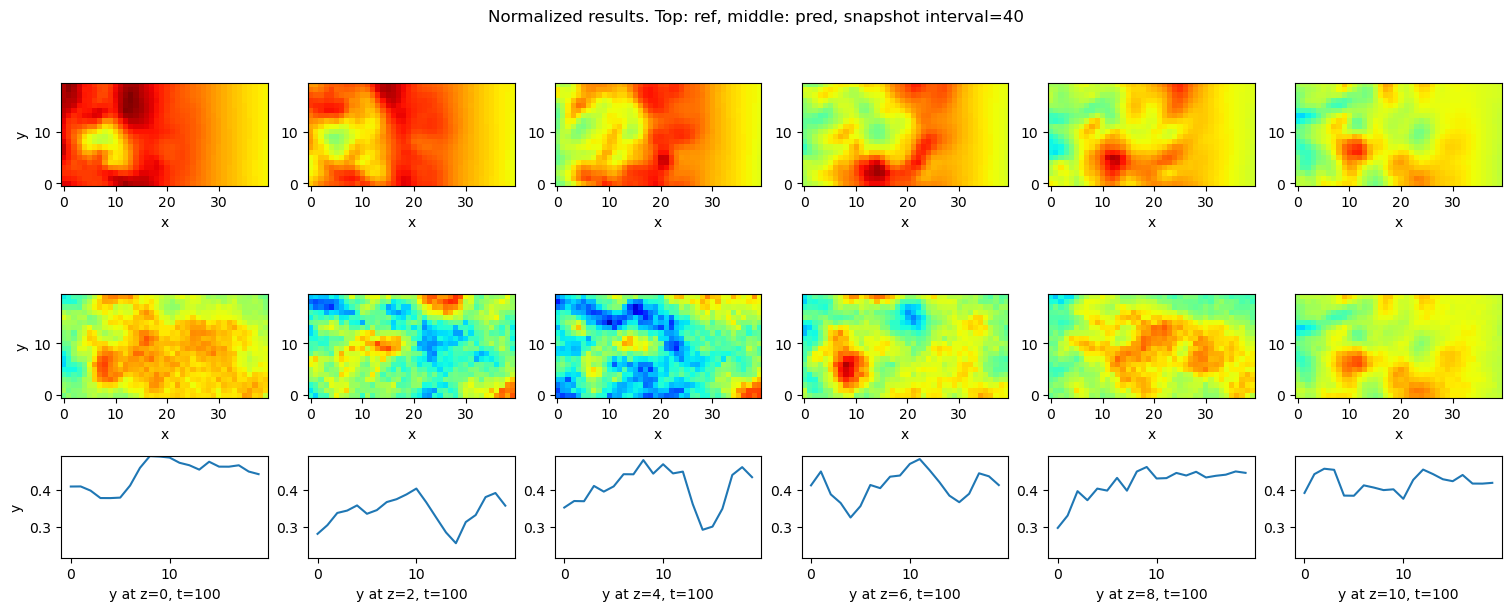

In [25]:
plt_zgap = 2
plt_t = 100
vmin = refvelocity_norm[plt_t,...,::plt_zgap,0].min()
vmax = refvelocity_norm[plt_t,...,::plt_zgap,0].max()
fig,axes = plt.subplots(3,6,figsize=(15,6),height_ratios=(0.4,0.4,0.2))
fig.suptitle(f'Normalized results. Top: ref, middle: pred, snapshot interval={plt_step}')
for i in range(6):
    axes[2,i].plot(inns_norm[plt_t,:,i*plt_zgap])
    axes[2,i].set(xlabel=f'y at z={i*plt_zgap}, t={plt_t}', ylim=[inns_norm[plt_t,:,::plt_zgap].min(), inns_norm[plt_t,:,::plt_zgap].max()])
    axes[0,i].imshow(refvelocity_norm[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[0,i].set(xlabel='x')
    axes[1,i].imshow(predv1_norm[plt_t,:,:,i*plt_zgap,0].T, vmin=vmin, vmax=vmax)
    axes[1,i].set(xlabel='x')
axes[0,0].set_ylabel('y')
axes[1,0].set_ylabel('y')
axes[2,0].set_ylabel('y')
plt.show()

## Train on volume 

### Correct for z locations

In [31]:
import haiku as hk

v_resize = jax.vmap(jax.tree_util.Partial(jax.image.resize,method='linear'),(-1,None),-1)
vv_resize = jax.vmap(v_resize,(0,None),0)
[key] = jax.random.split(key,1)

In [93]:
def forward3(x,p,z_coord):
    l1 = hk.Conv2D(4,3)
    l2 = hk.Conv2D(8,3)
    l3 = [hk.Linear(n) for n in [50,10]]
    l4 = [hk.Linear(n) for n in [100,50,10]]
    l5 = [hk.Linear(n) for n in [128,256, 512, 1024, 40*20*3]]

    def inner(x1,p1,z_coord):
        # print(x1.shape,p1.shape,z_coord.shape)
        x1 = l1(x1)
        x1 = vv_resize(x1, (20,10))
        x1 = jnp.tanh(x1)
        x1 = l2(x1)
        x1 = vv_resize(x1, (10,5))
        x1 = jnp.tanh(x1)
        x1 = x1.reshape((-1,10*5*8))
        for l in l3:
            x1 = l(x1)
            x1 = jnp.tanh(x1)
        for l in l4:
            p1 = l(p1)
            p1 = jnp.tanh(p1)
        # print(x1.shape,p1.shape,z_coord.shape)
        out = jnp.concatenate((x1,p1,z_coord,),axis=1)
        # print(out.shape)
        for l in l5[:-1]:
            out = l(out)
            out = jnp.tanh(out)
        return l5[-1](out).reshape((-1,40,20,3))
    return jax.vmap(inner, (0,0,None),0)(x,p,z_coord.reshape((20,1)))

In [100]:
z_coord = (jnp.arange(0,20)-10)/10
inns3_group = (jnp.einsum('txyzu -> tzxyu', predv1_norm)[:,...], jnp.einsum('tyz -> tzy', inns_norm)[:,...], z_coord)

In [ ]:
mdl3 = hk.transform(forward3)
params3 = mdl3.init(key, jnp.einsum('txyzu -> tzxyu', predv1_norm)[:10,...], jnp.einsum('tyz -> tzy', inns_norm)[:10,...], z_coord)
mdl3_apply = jax.jit(mdl3.apply)

In [98]:
jax.tree_map(lambda x: print(x.shape), params3)

(4,)
(3, 3, 3, 4)
(8,)
(3, 3, 4, 8)
(50,)
(400, 50)
(10,)
(50, 10)
(100,)
(20, 100)
(50,)
(100, 50)
(10,)
(50, 10)
(128,)
(21, 128)
(256,)
(128, 256)
(512,)
(256, 512)
(1024,)
(512, 1024)
(2400,)
(1024, 2400)


{'conv2_d': {'b': None, 'w': None},
 'conv2_d_1': {'b': None, 'w': None},
 'linear': {'b': None, 'w': None},
 'linear_1': {'b': None, 'w': None},
 'linear_2': {'b': None, 'w': None},
 'linear_3': {'b': None, 'w': None},
 'linear_4': {'b': None, 'w': None},
 'linear_5': {'b': None, 'w': None},
 'linear_6': {'b': None, 'w': None},
 'linear_7': {'b': None, 'w': None},
 'linear_8': {'b': None, 'w': None},
 'linear_9': {'b': None, 'w': None}}

In [97]:
lr = 0.0001
scheduler3 = optimiser_options.get_scheduler('exponential_decay', lr)
optimiser3 = optax.adamw(learning_rate=scheduler3)
opt_state3 = optimiser3.init(params3)
state3 = train.TrainingState(params=params3, opt_state=opt_state3)
mdl3_apply(state3.params, key, jnp.einsum('txyzu -> tzxyu', predv1_norm)[:10,...], jnp.einsum('tyz -> tzy', inns_norm)[:10,...], z_coord).shape

(10, 20, 40, 20, 3)

In [101]:
y_norm.shape

(200, 40, 20, 3)

In [107]:
def loss3(apply_fn, params, rng, inns_group, y):
    pred = apply_fn(params, rng, *inns_group)
    pred = jnp.einsum('tzxyu -> txyzu', pred)
    pred_new = pred.at[:,:,:,z_plane,:].set(y)
    ldiv = losses.divergence(pred_new, datainfo)
    ld = losses.mse(pred[:,:,:,z_plane,:], y)
    return 100*ld + ldiv, {'plane': ld, 'div':ldiv}
update3 = train.generate_update_fn(mdl3_apply, optimiser3, loss3, kwargs_value_and_grad={'has_aux':True})
l,_ = update3(state3, key, inns3_group, y_norm)
print(l)

(Array(60.95142, dtype=float32), {'div': Array(52.28725, dtype=float32), 'plane': Array(0.0866417, dtype=float32)})
